<a href="https://colab.research.google.com/github/realalyeasin/Machine-Learning/blob/main/%E2%9A%99%EF%B8%8FTransfer_Learning_and_Fine_Tuning%F0%9F%94%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory  

**Data Preprocessing**

---



---



In [3]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size= IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir,
                                             shuffle = True,
                                             batch_size = BATCH_SIZE,
                                             image_size= IMG_SIZE)

68608000/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


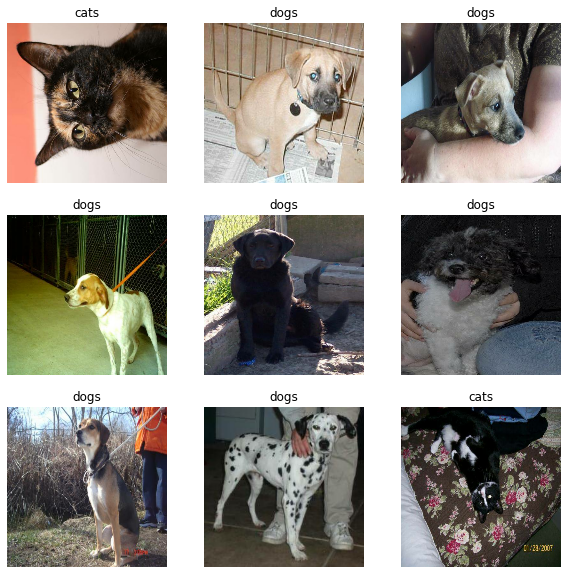

In [4]:
class_names = train_dataset.class_names
plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [6]:
print("Number of validation batches %d" % tf.data.experimental.cardinality(validation_dataset))
print("Number of test batches %d" % tf.data.experimental.cardinality(test_dataset))

Number of validation batches 26
Number of test batches 6


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
                                         tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                                         tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

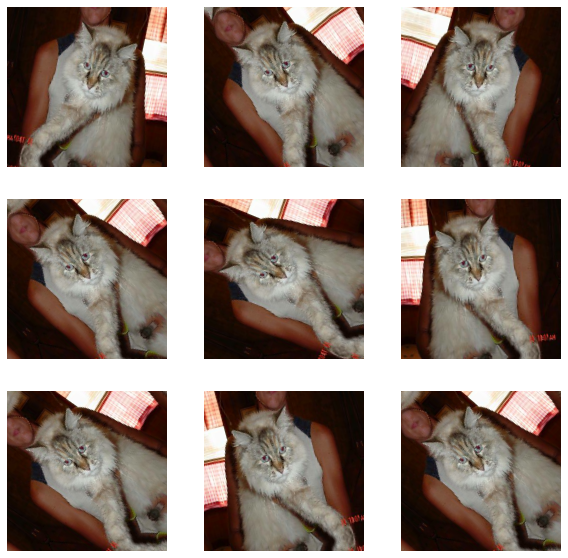

In [9]:
for images, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = images[0]
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    augmentated_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmentated_image[0]/ 255)
    plt.axis("off")

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [11]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1)

**Creating Base Model from Pre-Trained**

---



---



In [12]:
IMG_SHAPE = IMG_SIZE +(3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top = False,
                                               weights = 'imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [14]:
base_model.trainable = False

In [15]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 5, 5, 1)


In [18]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs =  prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

**Compile Model**

---


---




In [19]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = 10
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 14s 465ms/step - loss: 0.7705 - accuracy: 0.4889


In [23]:
print("Initial Loss : {:.2f}".format(loss0))
print("Initial Accuracy : {:.2f}".format(accuracy0))

Initial Loss : 0.77
Initial Accuracy : 0.49


In [24]:
history = model.fit(train_dataset,
                   epochs = initial_epochs,
                   validation_data = validation_dataset)

Epoch 1/10
63/63 [==============================] - 51s 750ms/step - loss: 0.7021 - accuracy: 0.5680 - val_loss: 0.5443 - val_accuracy: 0.6621
Epoch 2/10
63/63 [==============================] - 48s 755ms/step - loss: 0.5444 - accuracy: 0.6950 - val_loss: 0.3967 - val_accuracy: 0.7983
Epoch 3/10
63/63 [==============================] - 48s 759ms/step - loss: 0.4349 - accuracy: 0.7795 - val_loss: 0.3056 - val_accuracy: 0.8688
Epoch 4/10
63/63 [==============================] - 48s 753ms/step - loss: 0.3600 - accuracy: 0.8270 - val_loss: 0.2485 - val_accuracy: 0.8998
Epoch 5/10
63/63 [==============================] - 47s 748ms/step - loss: 0.3197 - accuracy: 0.8490 - val_loss: 0.2123 - val_accuracy: 0.9257
Epoch 6/10
63/63 [==============================] - 48s 756ms/step - loss: 0.3004 - accuracy: 0.8655 - val_loss: 0.1847 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 48s 762ms/step - loss: 0.2765 - accuracy: 0.8770 - val_loss: 0.1645 - val_accuracy: 0.9381

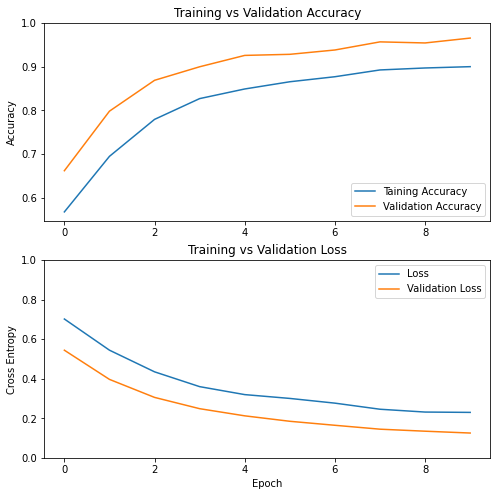

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(acc, label='Taining Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training vs Validation Accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [32]:
base_model.trainable = True

In [33]:
print("Number of layers in the base model :", len(base_model.layers))

Number of layers in the base model : 154


In [34]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [35]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [36]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [37]:
len(model.trainable_variables)

56

In [40]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs = total_epochs,
                         initial_epoch = history.epoch[-1],
                         validation_data = validation_dataset)

Epoch 10/20
63/63 [==============================] - 77s 1s/step - loss: 0.1514 - accuracy: 0.9355 - val_loss: 0.0593 - val_accuracy: 0.9752
Epoch 11/20
63/63 [==============================] - 72s 1s/step - loss: 0.1151 - accuracy: 0.9570 - val_loss: 0.0451 - val_accuracy: 0.9802
Epoch 12/20
63/63 [==============================] - 73s 1s/step - loss: 0.1113 - accuracy: 0.9575 - val_loss: 0.0401 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 72s 1s/step - loss: 0.0927 - accuracy: 0.9665 - val_loss: 0.0363 - val_accuracy: 0.9827
Epoch 14/20
63/63 [==============================] - 72s 1s/step - loss: 0.0897 - accuracy: 0.9645 - val_loss: 0.0353 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 72s 1s/step - loss: 0.0684 - accuracy: 0.9740 - val_loss: 0.0400 - val_accuracy: 0.9851
Epoch 16/20
63/63 [==============================] - 72s 1s/step - loss: 0.0624 - accuracy: 0.9730 - val_loss: 0.0382 - val_accuracy: 0.9864
Epoch 17/20
6

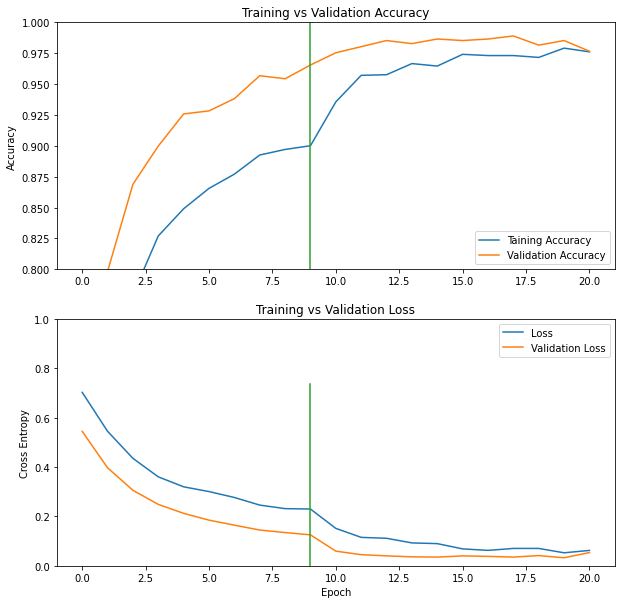

In [41]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(acc, label='Taining Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.ylabel("Accuracy")
plt.ylim([0.8,1])
plt.title("Training vs Validation Accuracy")

plt.subplot(2,1,2)
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")

plt.show()

In [42]:
loss, accuracy = model.evaluate(test_dataset)
print('Test Accuracy :', accuracy)

6/6 [==============================] - 3s 469ms/step - loss: 0.0362 - accuracy: 0.9896
Test Accuracy : 0.9895833134651184


Predictions : 
 [1 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1]
Label : 
 [1 1 0 0 1 0 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 0 1 0 0 0 1]


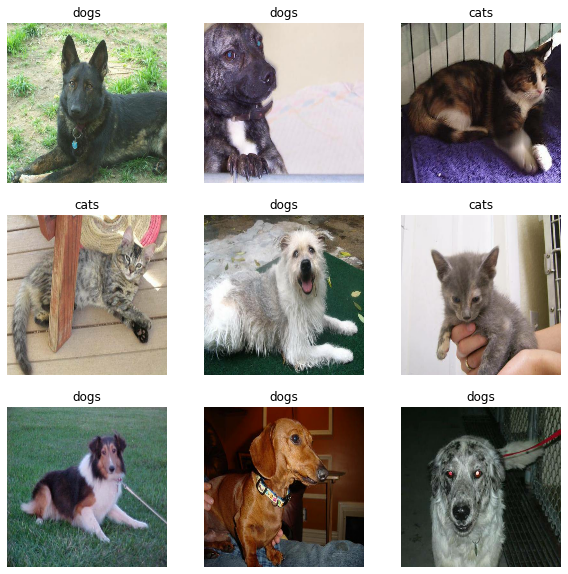

In [46]:
image_batch , label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions<0.5,0,1)

print("Predictions : \n", predictions.numpy())
print("Label : \n", label_batch)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")